In [1]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))


import numpy as np
from scipy.optimize import differential_evolution
from stress_strain_analysis import stress_strain_analysis
from mesh import Mesh
import geometry

# Define your geometry and mesh
ReinforcedConcrete = geometry.ReinforcedConcreteColumn(width  = 300, 
                                                       height = 300, 
                                                       concrete_cover = 30,
                                                       rebar_diameter = 20,
                                                       rebar_spacing  = 50)
Mesh = Mesh(ReinforcedConcrete, "triangle", 25)

In [2]:
import time
# Initialize the stress-strain analysis
analysis = stress_strain_analysis(Mesh, Nx=1700, My=180)

def callback(xk, convergence):
    residual = analysis.find_strain_and_curvature(xk)
    return residual < 1e-9  # Stop when condition is met

# Define bounds for eps and xsi
bounds = [(-0.01, 0.01), (-0.001, 0.001)]
start_time = time.perf_counter()
result = differential_evolution(analysis.find_strain_and_curvature, 
                                bounds=bounds, 
                                callback=callback,
                                tol=1e-6,  # Additional tolerance setting
                                strategy='best1bin', 
                                maxiter=1000)

# End timing
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time

print("Optimal solution:", result.x)
print("Number of iterations:", result.nit)
print("Minimum residual:", result.fun)
print(f"Execution Time: {elapsed_time:.4f} seconds")

Optimal solution: [8.06302502e-04 1.18418014e-05]
Number of iterations: 48
Minimum residual: 0.02836907571044375
Execution Time: 2.6387 seconds


0.0008063025018666115 1.184180139583213e-05
Nx =  1598.794230587947 kN
My =  151.6393329922786 kNm


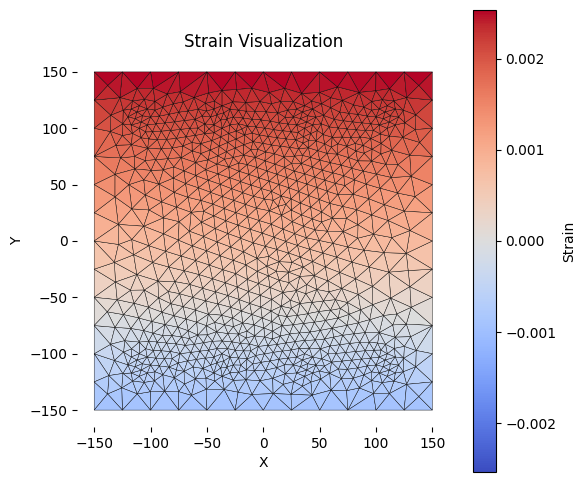

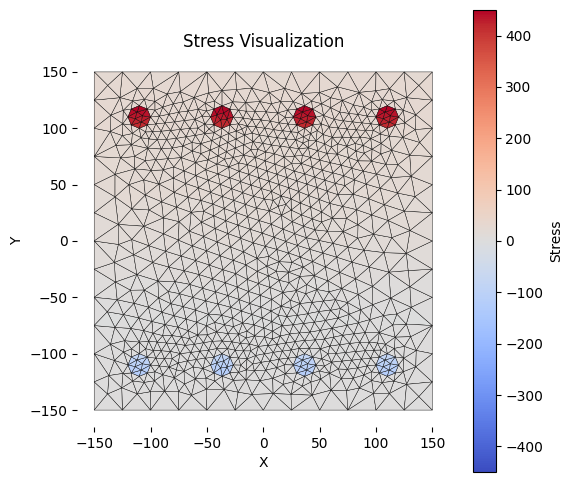

In [3]:
eps, xsi = result.x[0],result.x[1]
print(eps, xsi)
analysis.set_strain_and_curvature(eps, xsi)
analysis.calculate_strains()
analysis.calculate_stresses()
print("Nx = ", analysis.get_section_forces()[0], "kN")
print("My = ", analysis.get_section_forces()[1], "kNm")
analysis.plot_strains()
analysis.plot_stresses()

In [4]:
from scipy.optimize import fsolve
target_N = 1700
target_M = 180
# Define system of equations for fsolve
def system_of_equations(V, target_N, target_M):
    # Set strain and curvature
	analysis.set_strain_and_curvature(V[0], V[1])

    # Calculate section forces
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
    # Return the system of equations
	return [Nx - target_N, My - target_M]

# Initial guess for eps and xsi
initial_guess = [0.0000, 0.00000]  


start_time = time.perf_counter()
# Solve with fsolve
result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M))
# End timing
end_time = time.perf_counter()
# Calculate elapsed time
elapsed_time = end_time - start_time

print("Optimal Solution:", result)
print("Residual (Post-Check):", system_of_equations(result, target_N, target_M))
print(f"Execution Time: {elapsed_time:.4f} seconds")


Optimal Solution: [8.59162790e-04 1.13291409e-05]
Residual (Post-Check): [-34.74691013774759, -31.513123001294275]
Execution Time: 0.0085 seconds


C:\Users\fabio\AppData\Local\Temp\ipykernel_15552\157719281.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M))


0.000859162790491106 1.1329140854563193e-05
Nx =  1665.2530898622524 kN
My =  148.48687699870572 kNm


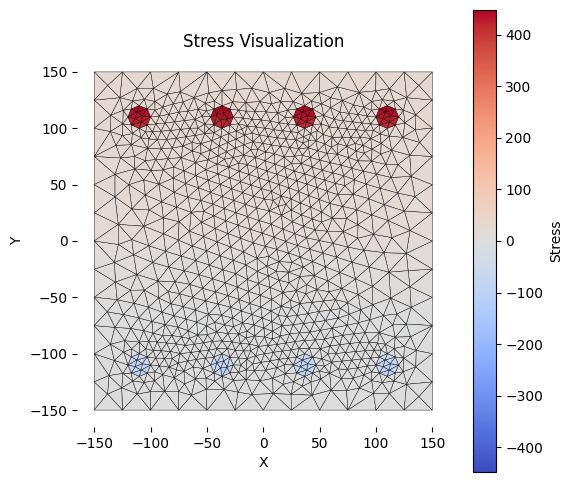

In [5]:
eps, xsi = result[0],result[1]
print(eps, xsi)
analysis.set_strain_and_curvature(eps, xsi)
analysis.calculate_strains()
analysis.calculate_stresses()
print("Nx = ", analysis.get_section_forces()[0], "kN")
print("My = ", analysis.get_section_forces()[1], "kNm")
analysis.plot_stresses()

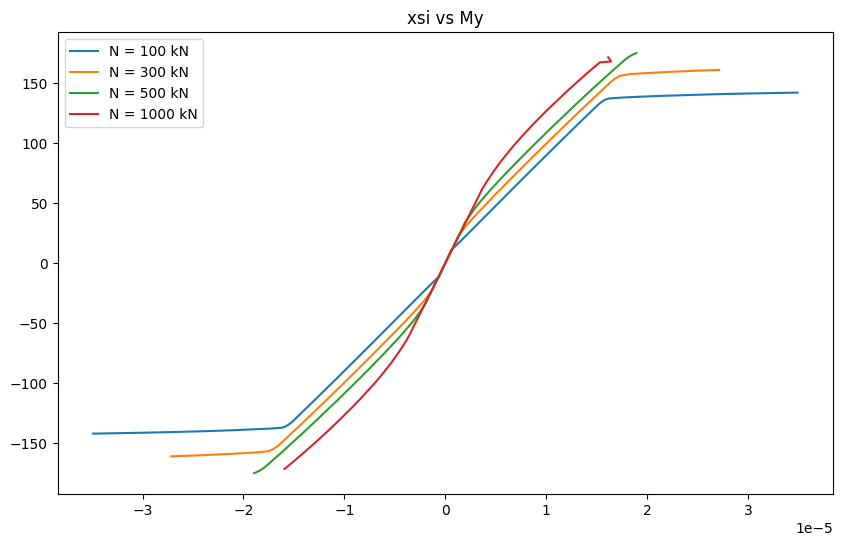

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(-175, 175, 501)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, M_target):
	analysis.set_strain_and_curvature(V[0], V[1])
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
	return [Nx - N_target, My - M_target]


# Plotting the results
plt.figure(figsize=(10, 6))
for target_N in [100, 300, 500, 1000]:
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	plt.plot(xsi, M_res,linestyle='-', label=f'N = {target_N} kN')

# Plotting the results
plt.title('xsi vs My')
plt.legend()
plt.show()

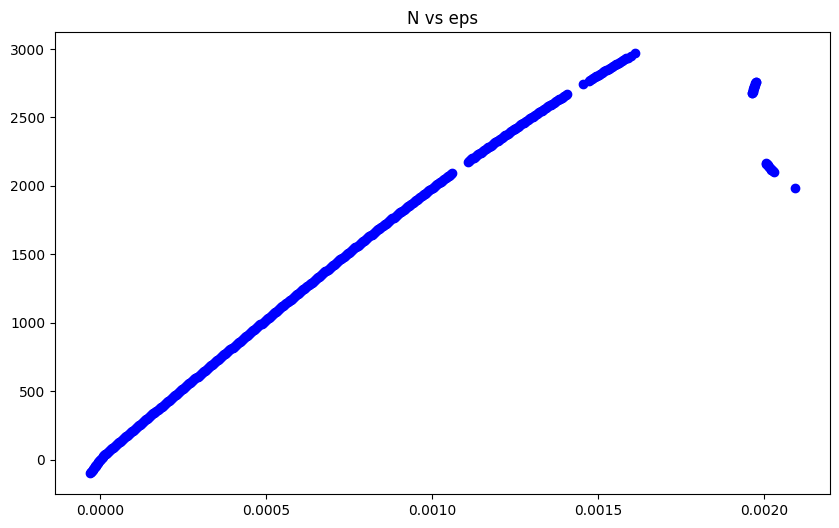

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-2000, 3000, 801)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, M_target):
	analysis.set_strain_and_curvature(V[0], V[1])
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
	return [Nx - N_target, My - M_target]


eps = []
N_res = []
for i, target_N in enumerate(N):
	target_M = 0
	initial_guess = [0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		eps.append(result[0][0])  # Append the xsi value
		N_res.append(target_N)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(eps, N_res,linestyle='-', color='b')
plt.title('N vs eps')
plt.show()

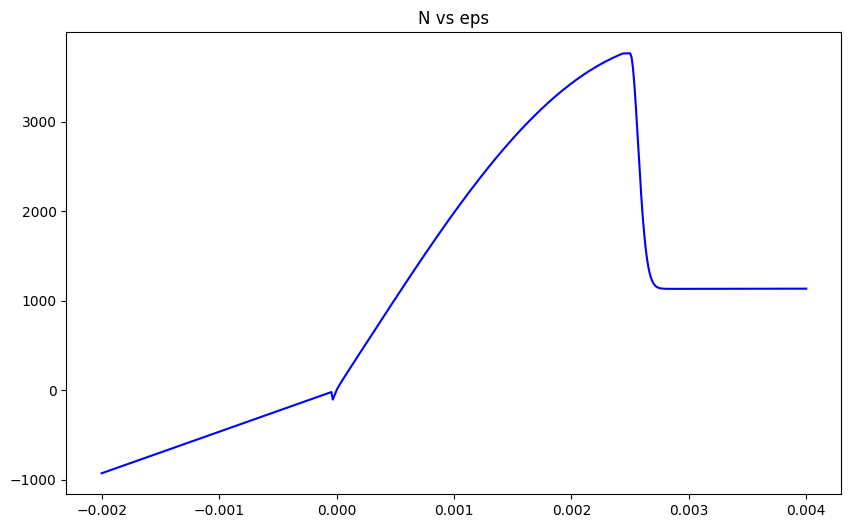

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

eps = np.linspace(-0.002, 0.004, 501)
N = []

for i, e in enumerate(eps):
    analysis.set_strain_and_curvature(e, 0)
    analysis.calculate_strains()
    analysis.calculate_stresses()
    N.append(analysis.get_section_forces()[0])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(eps, N,linestyle='-', color='b')
plt.title('N vs eps')
plt.show()

Calculating for N =  -100.0
Calculating for N =  -50.0
Calculating for N =  0.0
Calculating for N =  50.0
Calculating for N =  100.0
Calculating for N =  150.0
Calculating for N =  200.0
Calculating for N =  250.0
Calculating for N =  300.0
Calculating for N =  350.0
Calculating for N =  400.0
Calculating for N =  450.0
Calculating for N =  500.0
Calculating for N =  550.0
Calculating for N =  600.0
Calculating for N =  650.0
Calculating for N =  700.0
Calculating for N =  750.0
Calculating for N =  800.0
Calculating for N =  850.0
Calculating for N =  900.0
Calculating for N =  950.0
Calculating for N =  1000.0
Calculating for N =  1050.0
Calculating for N =  1100.0
Calculating for N =  1150.0
Calculating for N =  1200.0
Calculating for N =  1250.0
Calculating for N =  1300.0
Calculating for N =  1350.0
Calculating for N =  1400.0
Calculating for N =  1450.0
Calculating for N =  1500.0
Calculating for N =  1550.0
Calculating for N =  1600.0
Calculating for N =  1650.0
Calculating for 

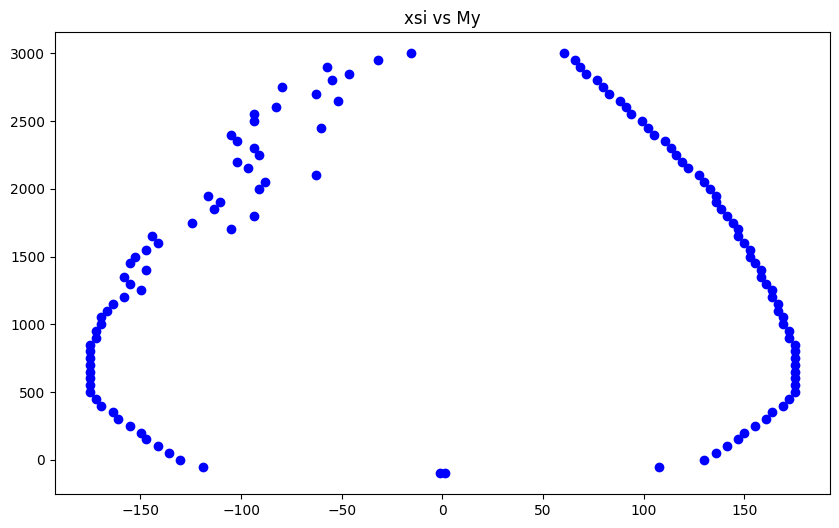

m_max =  60.19999999999999
m_min =  -15.400000000000006


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-100, 3000, 63)
My = np.linspace(-175, 175, 126)
M_min = []
M_max = []

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, M_target):
	analysis.set_strain_and_curvature(V[0], V[1])
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
	return [Nx - N_target, My - M_target]

for i, N_target in enumerate(N):
	xsi = []
	M_res = []
	print("Calculating for N = ", N_target)
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, target_M), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	M_min.append(min(M_res))
	M_max.append(max(M_res))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(M_min, N,linestyle='-', color='b')
plt.scatter(M_max, N,linestyle='-', color='b')
plt.title('xsi vs My')
plt.show()
print("m_max = ", max(M_res))
print("m_min = ", min(M_res))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-100, 3000, 63)
My = np.linspace(-175, 175, 71)
M_min = []
M_max = []

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, M_target):
	analysis.set_strain_and_curvature(V[0], V[1])
	analysis.calculate_strains()
	analysis.calculate_stresses()
	Nx, My = analysis.get_section_forces()
	return [Nx - N_target, My - M_target]

for i, N_target in enumerate(N):
	xsi = []
	M_res = []
	print("Calculating for N = ", N_target)
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = differential_evolution(analysis.find_strain_and_curvature, 
                                bounds=bounds, 
                                callback=callback,
                                tol=1e-6,  # Additional tolerance setting
                                strategy='best1bin', 
                                maxiter=1000)
		# Check if the solution converged
		if result.nit != 1000:
			xsi.append(result.x[1])  # Append the xsi value
			M_res.append(M)
	M_min.append(min(M_res))
	M_max.append(max(M_res))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(M_min, N,linestyle='-', color='b')
plt.scatter(M_max, N,linestyle='-', color='b')
plt.title('xsi vs My')
plt.show()
print("m_max = ", max(M_res))
print("m_min = ", min(M_res))

Calculating for N =  -100.0
Calculating for N =  -50.0
Calculating for N =  0.0
Calculating for N =  50.0
Calculating for N =  100.0
Calculating for N =  150.0
Calculating for N =  200.0
Calculating for N =  250.0
Calculating for N =  300.0
Calculating for N =  350.0
Calculating for N =  400.0
Calculating for N =  450.0
Calculating for N =  500.0
Calculating for N =  550.0
Calculating for N =  600.0
Calculating for N =  650.0


KeyboardInterrupt: 